In [1]:
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# reading the JSON data using json.load()
file = './data/GoogleLocation2018.json'
with open(file) as train_file:
    data_json = json.load(train_file)
    
df = pd.DataFrame({'raw': data_json['locations']})

In [3]:
# Extract the base data
df['timeMs'] = df.apply(lambda row: int(row.raw['timestampMs']), axis=1)
df['lat'] = df.apply(lambda row: row.raw['latitudeE7'] / 10_000_000, axis=1)
df['lon'] = df.apply(lambda row: row.raw['longitudeE7'] / 10_000_000, axis=1)
df['acc'] = df.apply(lambda row: row.raw['accuracy'], axis=1)

df = df[df.acc < 100]

df.drop(columns='raw', inplace=True)
# Derivatives
df['date'] = pd.to_datetime(df.timeMs, unit='ms')
df['year'] = df.apply(lambda row: row.date.year, axis=1)
df['month'] = df.apply(lambda row: row.date.month, axis=1)
df['day'] = df.apply(lambda row: row.date.day, axis=1)
df['hour'] = df.apply(lambda row: row.date.hour, axis=1)
df['duration'] = (df.timeMs.shift(1) - df.timeMs.shift(-1))/ 2 / (1000*60*60)

In [4]:
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)

# Setting the geometry by hand: http://geopandas.org/projections.html
gdf.crs = {'init' :'epsg:4326'}

In [5]:
def counts(series):
    return series.value_counts().to_json()

In [13]:
day_stats = gdf.groupby(['year', 'month', 'day']).agg({'lat': ['min', 'max', 'var'], 'lon': ['min', 'max', 'var']})

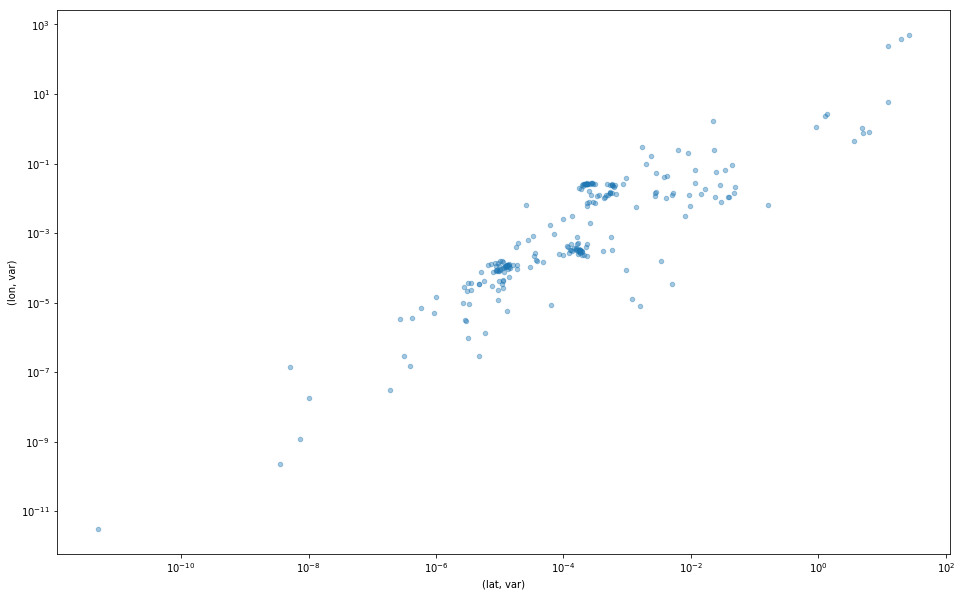

In [15]:
selection = day_stats[day_stats['lon']['var']!=0]

selection.plot(x=2, y=5, logx=True, logy=True, alpha=0.4, figsize=(16, 10), kind='scatter')